(metropolis_notebook)=
# Approssimazione della distribuzione a posteriori

In generale, in un problema bayesiano i dati $y$ provengono da una densità $p(y \mid \theta)$ e al parametro $\theta$ viene assegnata una densità a priori $p(\theta)$. Dopo avere osservato i dati $Y = y$, la funzione di verosimiglianza è uguale a $\mathcal{L}(\theta) = p(y \mid \theta)$ e la densità a posteriori diventa

$$
p(\theta \mid y) = \frac{p(y \mid \theta) p(\theta)}{p(y)}. 
$$

È dunque necessario calcolare l'*evidenza* $p(y)$. Per fare questo è necessario risolvere il seguente integrale in cui si integra su tutti i possibili valori $\theta$ dei parametri:

$$
p(y) = \int_{\theta} p(y \mid \theta) p(\theta) \,\operatorname {d}\! \theta. 
$$

Il problema fondamentale consiste nella difficoltà di valutare analiticamente tale integrale. Se vogliamo trovare la distribuzione a posteriori con metodi analitici, dobbiamo ricorrere all'impiego di distribuzioni a priori coniugate, come abbiamo fatto nello schema beta-binomiale. Per quanto "semplice" in termini formali, la scelta di distribuzioni a priori coniugate limita di molto le possibili scelte del ricercatore. Inoltre, non è sempre sensato, dal punto di vista teorico, utilizzare tali distribuzioni per la stima dei parametri di interesse. Il mancato ricorso all'impiego delle distribuzioni a priori coniugate richiede necessariamente il computo dell'espressione a denominatore della formula di Bayes che solo in rare occasioni può essere ottenuta per via analitica. In altre parole, è possibile ottenere analiticamenre la distribuzione a posteriori solo per alcune specifiche combinazioni di distribuzioni a priori e verosimiglianza, il che limita considerevolmente la flessibilità della modellizzazione.

Per questa ragione, la strada principale che viene seguita nella modellistica bayesiana è quella che porta a determinare la distribuzione a posteriori non per via analitica, ma bensì mediante metodi di approssimazione numerica. La simulazione fornisce dunque la strategia generale del calcolo bayesiano. A questo fine vengono principalmente usati i metodi di campionamento Monte Carlo basati su Catena di Markov (MCMC). Tali metodi costituiscono una potente e praticabile alternativa per la costruzione della distribuzione a posteriori per modelli complessi e consentono di decidere quali distribuzioni a priori e quali distribuzioni di verosimiglianza usare sulla base di considerazioni teoriche soltanto, senza dovere preoccuparsi di altri vincoli.

Dato che è basata su metodi computazionalmente intensivi, la stima numerica della funzione a posteriori può essere svolta soltanto mediante software. In anni recenti i metodi Bayesiani di analisi dei dati sono diventati sempre più popolari proprio perché la potenza di calcolo necessaria per svolgere tali calcoli è ora alla portata di tutti. Questo non era vero solo pochi decenni fa.

In questo capitolo descriviamo due metodi che possono essere usati come mezzo per calcolare la distribuzione a posteriori quando la distribuzione a priori coniugata non è applicabile.

-   *metodi basati su griglia:* dove, sebbene non sia disponibile alcuna formula algebrica in forma chiusa, le proprietà della distribuzione a posteriori possono essere calcolate con una precisione arbitraria;
-   *metodi Monte Carlo:* dove, utilizzando appropriate funzioni di numeri casuali, viene generato un grande campione di osservazioni della distribuzione a posteriori per poi stimare empiricamente la proprietà di interesse in base al campione così ottenuto.

## Metodo basato su griglia

Il metodo basato su griglia (*grid-based*) è un metodo numerico esatto basato su una griglia di punti uniformemente spaziati. Anche se la maggior parte dei parametri è continua (ovvero, in linea di principio ciascun parametro può assumere un numero infinito di valori), possiamo ottenere un'eccellente approssimazione della distribuzione a posteriori considerando solo una griglia finita di valori dei parametri. Con un tale metodo, dunque, la densità di probabilità a posteriori può essere approssimata tramite le densità di probabilità calcolate in ciascuna cella della griglia.

Il metodo basato su griglia si sviluppa in quattro fasi:

-   fissare una griglia discreta di possibili valori $\theta$;
-   valutare la distribuzione a priori $p(\theta)$ e la funzione di verosimiglianza $p(y \mid \theta)$ in corrispondenza di ciascun valore $\theta$ della griglia;
-   ottenere un'approssimazione discreta della densità a posteriori:
    -   per ciascun valore $\theta$ della griglia, calcolare il prodotto $p(\theta) p(y \mid \theta)$;
    -   normalizzare i prodotti così ottenuti in modo tale che la loro somma sia 1;
-   selezionare $n$ valori casuali della griglia in modo tale da ottenere un campione casuale delle densità a posteriori normalizzate.

È possibile migliorare l'approssimazione aumentando il numero di punti della griglia. Infatti utilizzando un numero infinito di punti si otterrebbe la descrizione esatta della distribuzione a posteriori, dovendo però pagare il costo dell'utilizzo di infinite risorse di calcolo. Il limite maggiore dell'approccio basato su griglia è proprio questo: al crescere della dimensionalità $n$ dello spazio dei parametri, i punti della griglia necessari per avere una buona stima crescono esponenzialmente con $n$, rendendo questo metodo inattuabile per problemi complessi.

### Modello Beta-Binomiale

Per fare un esempio, utilizziamo il metodo basato su griglia nel caso dello schema beta-binomiale di cui conosciamo la soluzione esatta. Esaminiamo nuovamente i dati di {cite:t}`zetsche_2019future`: 23 "successi" in 30 prove Bernoulliane indipendenti.

Imponendo alla distribuzione a priori su $\theta$ (probabilità di successo in una singola prova, laddove per "successo" si intende una aspettativa distorta negativamente dell'umore futuro) una $Beta(2, 10)$ per descrivere la nostra incertezza sul parametro prima di avere osservato i dati, il modello diventa:

$$
\begin{align}
Y \mid \theta & \sim Bin(n = 30, \theta), \notag\\
\theta & \sim Beta(2, 10).\notag
\end{align}
$$

In queste circostanze, l'aggiornamento bayesiano produce una distribuzione a posteriori Beta di parametri 25 ($y + \alpha$ = 23 + 2) e 17 ($n - y + \beta$ = 30 - 23 + 10):

$$
\theta \mid (y = 23) \sim Beta(25, 17).\notag
$$

Per approssimare una tale distribuzione a posteriori, scriviamo una funzione che produce l'approssimazione della distribuzione a posteriori basata su griglia usando la procedura descritta nel capitolo precedente.

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy.stats import norm
from scipy.stats import binom
from scipy.stats import beta
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.graphics import tsaplots
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
from scipy.constants import golden

In [ ]:
%matplotlib inline
sns.set_theme(
    context="paper",
    style="darkgrid",
    palette="colorblind",
    rc={'figure.figsize': (5.0, 5.0/golden)},
)
SEED = 12345
rng = np.random.default_rng(SEED)

: 

In [3]:
def posterior_grid_approx(grid_points=20, success=23, trials=30):
    """ """
    # define grid
    p_grid = np.linspace(0, 1, grid_points)

    # define prior
    unstd_prior = stats.beta.pdf(p_grid, 2, 10)
    prior = unstd_prior / sum(unstd_prior)

    # compute likelihood at each point in the grid
    likelihood = stats.binom.pmf(success, trials, p_grid)

    # compute product of likelihood and prior
    unstd_posterior = likelihood * prior

    # standardize the posterior, so it sums to 1
    posterior = unstd_posterior / unstd_posterior.sum()
    return p_grid, posterior

Fissiamo una griglia di $n = 1000$ valori equispaziati. Usando la funzione precedente, creaiamo un grafico della stima della distribuzione a posteriori a cui è stata sovrapposta l'esatta distribuzione a posteriori $Beta(25, 17)$).

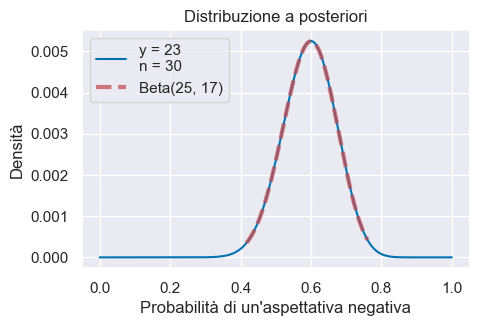

In [5]:
points = 1000
w, n = 23, 30
p_grid, posterior = posterior_grid_approx(points, w, n)
plt.plot(p_grid, posterior, "-", label="y = {}\nn = {}".format(w, n))

a = 25
b = 17
x = np.linspace(stats.beta.ppf(0.01, a, b), stats.beta.ppf(0.99, a, b), 1000)
plt.plot(
    x, stats.beta.pdf(x, a, b) / 1000, "r--", lw=3, alpha=0.75, label="Beta(25, 17)"
)

plt.xlabel("Probabilità di un'aspettativa negativa")
plt.ylabel("Densità")
plt.title("Distribuzione a posteriori")
plt.legend(loc=0)

In conclusione, il metodo basato su griglia è molto intuitivo e non richiede particolari competenze di programmazione per essere implementato. Inoltre, fornisce un risultato che, per tutti gli scopi pratici, può essere considerato come un campione casuale estratto da $p(\theta \mid y)$. Tuttavia, anche se tale metodo fornisce risultati accuratissimi, esso ha un uso limitato. A causa della *maledizione della dimensionalità*[^036_posterior_sim-1], tale metodo può solo essere usato nel caso di semplici modelli statistici, con non più di due parametri. Nella pratica concreta tale metodo viene dunque sostituito da altre tecniche più efficienti in quanto, anche nei più comuni modelli utilizzati in psicologia, vengono solitamente stimati centinaia se non migliaia di parametri.

[^036_posterior_sim-1]: Per capire cosa sia la maledizione della dimensionalità, supponiamo di utilizzare una griglia di 100 punti equispaziati. Nel caso di un solo parametro, è necessario calcolare 100 valori. Per due parametri devono essere calcolari $100^2$ valori. Ma già per 10 parametri è necessario calcolare $10^{10}$ valori -- è facile capire che una tale quantità di calcoli è troppo grande anche per un computer molto potente. Per modelli che richiedono la stima di un numero non piccolo di parametri è dunque necessario procedere in un altro modo.

## Metodo Monte Carlo 

I metodi più ampiamente adottati nell'analisi bayesiana per la costruzione della distribuzione a posteriori per modelli complessi sono i metodi di campionamento MCMC. Tali metodi consentono al ricercatore di decidere quali distribuzioni a priori e quali distribuzioni di verosimiglianza usare sulla base di considerazioni teoriche soltanto, senza doversi preoccupare di altri vincoli. Dato che è basata su metodi computazionalmente intensivi, la stima numerica MCMC della funzione a posteriori può essere svolta soltanto mediante software. In anni recenti i metodi Bayesiani di analisi dei dati sono diventati sempre più popolari proprio perché la potenza di calcolo necessaria per svolgere tali calcoli è ora alla portata di tutti. Questo non era vero solo pochi decenni fa.

### Integrazione di Monte Carlo

Il termine Monte Carlo si riferisce al fatto che la computazione fa ricorso ad un ripetuto campionamento casuale attraverso la generazione di sequenze di numeri casuali. Una delle sue applicazioni più potenti è il calcolo degli integrali mediante simulazione numerica. Un'illustrazione è fornita dal seguente esempio. Supponiamo di essere in grado di estrarre campioni casuali dalla distribuzione continua $p(\theta \mid y)$ di media $\mu$. Se possiamo ottenere una sequenza di realizzazioni indipendenti

$$
\theta^{(1)}, \theta^{(2)},\dots, \theta^{(T)} \overset{\text{iid}}{\sim} p(\theta \mid y)
$$

allora diventa possibile calcolare

$$
\mathbb{E}(\theta \mid y) = \int \theta p(\theta \mid y) \,\operatorname {d}\!\theta \approx \frac{1}{T} \sum_{i=1}^T \theta^{(t)}.
$$

In altre parole, l'aspettazione teorica di $\theta$ può essere approssimata dalla media campionaria di un insieme di realizzazioni indipendenti ricavate da $p(\theta \mid y)$. Per la Legge Forte dei Grandi Numeri, l'approssimazione diventa arbitrariamente esatta per $T \rightarrow \infty$.[^036_posterior_sim-2]

[^036_posterior_sim-2]: L'integrazione Monte Carlo può essere utilizzata anche per la valutazione di integrali più complessi.

Quello che è stato detto sopra non è altro che un modo sofisticato per dire che, se vogliamo calcolare un'approssimazione del valore atteso di una variabile casuale, non dobbiamo fare altro che la media aritmetica di un grande numero di realizzazioni indipendenti della variabile casuale. Come è facile intuire, l'approssimazione migliora al crescere del numero dei dati che abbiamo a disposizione.

Un'altra importante funzione di $\theta$ è la funzione indicatore, $I(l < \theta < u)$, che assume valore 1 se $\theta$ giace nell'intervallo $(l, u)$ e 0 altrimenti. Il valore di aspettazione di $I(l < \theta < u)$ rispetto a $p(\theta)$ dà la probabilità che $\theta$ rientri nell'intervallo specificato, $Pr(l < \theta < u)$. Anche questa probabilità può essere approssimato usando l'integrazione Monte Carlo, ovvero prendendo la media campionaria del valore della funzione indicatore per ogni realizzazione $\theta^{(t)}$. È semplice vedere come

$$
Pr(l < \theta < u) \approx \frac{\text{numero di realizzazioni } \theta^{(t)} \in (l, u)}{T}.
$$

Abbiamo fornito qui alcuni accenni relativi all'integrazione di Monte Carlo perché, nell'analisi bayesiana, il metodo Monte Carlo viene usato per ottenere un'approssimazione della distribuzione a posteriori, quando tale distribuzione non può essere calcolata con metodi analitici. In altre parole, il metodo Monte Carlo consente di ottenere un gran numero di valori $\theta$ che, nelle circostanze ideali, avrà una distribuzione identica alla distribuzione a posteriori $p(\theta \mid y)$.

### Campionamento dalla distribuzione a posteriori

Poniamoci ora il problema di approssimare la distribuzione a posteriori con una simulazione. Consideriamo nuovamente i dati di {cite:t}`zetsche_2019future` (ovvero, 23 "successi" in 30 prove Bernoulliane) e, come in precedenza, assumiamo per $\theta$ una distribuzione a priori $Beta(2, 10)$. In tali circostanze, la distribuzione a posteriori può essere ottenuta analiticamente tramite lo schema beta-binomiale ed è una $Beta(25, 17)$. Se vogliamo conoscere il valore della media a posteriori di $\theta$, il risultato esatto è

$$
\bar{\theta}_{post} = \frac{\alpha}{\alpha + \beta} = \frac{25}{25 + 17} \approx 0.5952.
$$

È anche possibile ottenere il valore della media a posteriori con una simulazione numerica. Conoscendo la forma della la distribuzione a posteriori, possiamo estrarre un campione di osservazioni da una $Beta(25, 17)$ per poi calcolare la media delle osservazioni ottenute. Con poche osservazioni (diciamo 10) otteniamo un risultato molto approssimato.

In [6]:
y = beta(25, 17).rvs(10)
print(*y)

0.6300646835801903 0.4787658639515109 0.605664958646668 0.6762717986809225 0.6344207619588883 0.5840665614805872 0.5900911296867813 0.6396293233425911 0.5737759450246442 0.7969614608756499


In [7]:
y.mean()

0.6209712487228435

L'approssimazione migliora all'aumentare del numero di osservazioni.

In [8]:
beta(25, 17).rvs(100000).mean()

0.5952192016043374

Lo stesso si può dire delle altre statistiche descrittive: moda, varianza, eccetera.

Questa simulazione, detta di Monte Carlo, produce il risultato desiderato perché

-   sappiamo che la distribuzione a posteriori è una $Beta(25, 17)$,
-   è possibile usare le funzioni Python per estrarre campioni casuali da una tale distribuzione.

Tuttavia, capita raramente di usare una distribuzione a priori coniugata alla verosimiglianza. Quindi, in generale, le due condizioni descritte sopra non si applicano. Ad esempio, nel caso di una verosimiglianza binomiale e di una distribuzione a priori gaussiana, la distribuzione a posteriori di $\theta$ è

$$
p(\theta \mid y) = \frac{\mathrm{e}^{-(\theta - 1 / 2)^2} \theta^y (1 - \theta)^{n - y}} {\int_0^1 \mathrm{e}^{-(t - 1 / 2)^2} t^y (1 - t)^{n - y} dt}.
$$

Una tale distribuzione non è implementata in Python; dunque non possiamo usare Python per ottenere campioni casuali da una tale distribuzione.

In tali circostanze, però, è possibile ottenere ottenere un campione causale dalla distribuzione a posteriori procedendo in un altro modo. Questo risultato si ottiene utilizzando i metodi Monte Carlo basati su Catena di Markov (MCMC). I metodi MCMC, di cui l'algoritmo Metropolis è un caso particolare e ne rappresenta il primo esempio, sono una classe di algoritmi che consentono di ottenere campioni casuali da una distribuzione a posteriori *senza dovere conoscere la rappresentazione analitica di una tale distribuzione*.[^036_posterior_sim-3] Le tecniche MCMC sono il metodo computazionale maggiormente usato per risolvere i problemi dell'inferenza bayesiana.

[^036_posterior_sim-3]: In termini più formali, si può dire che i metodi MCMC consentono di costruire sequenze di punti (detti catene di Markov) nello spazio dei parametri le cui densità sono proporzionali alla distribuzione a posteriori. In altre parole, dopo aver simulato un grande numero di passi della catena si possono usare i valori così generati come se fossero un campione casuale della distribuzione a posteriori. Un'introduzione alle catene di Markov è fornita in Appendice.

## L'algoritmo di Metropolis

L'idea di base dell'algoritmo {cite:t}`metropolist_etal_1953` è campionare dalla distribuzione a posteriori combinando una "ricerca casuale" (l'aspetto Monte Carlo) con un meccanismo per "saltare" in modo intelligente, ma in un modo che alla fine non dipende da dove siamo partiti (una proprietà della Catena di Markov). Quindi i metodi Markov Chain Monte Carlo possono essere descritti come delle ricerche senza memoria (ovvero, senza distorsioni sistematiche) eseguite con dei "salti" intelligenti.

L'algoritmo Metropolis segue il seguente schema.

-  Iniziare l'algoritmo nella posizione corrente nello spazio dei parametri.
-  Proporre un "salto" in una nuova posizione nello spazio dei parametri.
-  Accettare o rifiutare il salto in modo probabilistico, utilizzando le informazioni precedenti e i dati disponibili.
-  Se il salto viene accettato, spostarsi nella nuova posizione e tornare al passaggio 1.
-  Se il salto viene rifiutato, restare nell'attuale posizione e tornare al passaggio 1.
-  Dopo che si è verificato un determinato numero di salti, restituire tutte le posizioni accettate.

Un'illustrazione visiva di come si svolge il processo di "esplorazione" dello spazio dei parametri dell'algoritmo Metropolis è fornita in questo post: https://elevanth.org/blog/2017/11/28/build-a-better-markov-chain/. La principale differenza tra i vari algoritmi MCMC risiede nel modo in cui si salta e nel modo in cui decide se saltare.

Esaminiamo più in dettaglio l'algoritmo Metropolis.

- Si inizia con un punto arbitrario $\theta^{(1)}$; quindi il primo valore $\theta^{(1)}$ della catena di Markov può corrispondere semplicemente ad un valore a caso tra i valori possibili del parametro.

- Per ogni passo successivo della catena, $m + 1$, si estrae un valore candidato $\theta'$ da una distribuzione proposta: $\theta' \sim \Pi(\theta)$. La distribuzione proposta può essere qualunque distribuzione, anche se, idealmente, è meglio che sia simile alla distribuzione a posteriori. In pratica, però, la distribuzione a posteriori è sconosciuta e quindi il valore $\theta'$ viene estratto a caso da una qualche distribuzione simmetrica centrata sul valore corrente $\theta^{(m)}$ del parametro. Nell'esempio presente useremo la gaussiana quale distribuzione proposta. La distribuzione proposta gaussiana sarà centrata sul valore corrente della catena e avrà una deviazione standard appropriata: $\theta' \sim \mathcal{N}(\theta^{(m)}, \sigma)$. In pratica, questo significa che, se $\sigma$ è piccola, il valore candidato $\theta'$ sarà simile al valore corrente $\theta^{(m)}$.

- Si calcola il rapporto $r$ tra il posteriore del parametro proposto $\theta'$ e il posteriore del parametro corrente $\theta^{(m)}$. Si noti che, utilizzando la regola di Bayes, l'eq. {eq}`eq-ratio-metropolis` cancella la costante di normalizzazione, $p(Y)$, dal rapporto. Il lato destro di quest'ultima uguaglianza contiene solo le verosimiglianze e i priori, entrambi facilmente calcolabili.

$$
r = \frac{p(\theta' \mid y)}{p(\theta^{(m)} \mid y)} = \frac{\frac{p(y \mid \theta') p(\theta')}{p(Y)}}{\frac{p(y \mid \theta^{(m)}) p(\theta^{(m)})}{p(Y)}} 
= \frac{p(y \mid \theta') p(\theta')}{p(y \mid \theta^{(m)}) p(\theta^{(m)})}.
$$ (eq-ratio-metropolis)

- Si decide se accettare il candidato $\theta'$ oppure se rigettarlo e estrarre un nuovo valore dalla distribuzione proposta. Possiamo pensare al rapporto $r$ come alla risposta alla seguente domanda: alla luce dei dati, quale stima di $\theta$ è più credibile, il valore candidato o il valore corrente? Se $r$ è maggiore di 1, ciò significa che il candidato è più credibile del valore corrente; dunque se $r$ è maggiore di 1 il candidato viene sempre accettato. Altrimenti, si decide di accettare il candidato con una probabilità minore di 1, ovvero non sempre, ma soltanto con una probabilità uguale ad $r$. Se $r$ è uguale a 0.10, ad esempio, questo significa che la credibilità a posteriori del valore candidato è 10 volte più piccola della credibilità a posteriori del valore corrente. Dunque, il valore candidato verrà accettato solo nel 10% dei casi. Come conseguenza di questa strategia di scelta, l'algoritmo Metropolis ottiene un campione casuale dalla distribuzione a posteriori, dato che la probabilità di accettare il valore candidato è proporzionale alla densità del candidato nella distribuzione a posteriori. Dal punto di vista algoritmico, tale procedura viene implementata confrontando il rapporto $r$ con un valore estratto a caso da una distribuzione uniforme $Unif(0, 1)$. Se $r > u \sim Unif(0, 1)$, allora il candidato $\theta'$ viene accettato e la catena si muove in quella nuova posizione, ovvero $\theta^{(m+1)} = \theta'$. Altrimenti $\theta^{(m+1)} = \theta^{(m)}$ e si estrae un nuovo candidato dalla distribuzione proposta.

- Il passaggio finale dell'algoritmo calcola l'*accettanza* in una specifica esecuzione dell'algoritmo, ovvero la proporzione di candidati $\theta'$ che sono stati accettati quali valori successivi della catena.

L'algoritmo Metropolis prende come input il numero $T$ di passi da simulare, la deviazione standard $\sigma$ della distribuzione proposta e la densità a priori, e ritorna come output la sequenza $\theta^{(1)}, \theta^{(2)}, \dots, \theta^{(T)}$. La chiave del successo dell'algoritmo Metropolis è il numero di passi fino a che la catena approssima la stazionarietà. Tipicamente i primi da 1000 a 5000 elementi sono scartati. Dopo un certo periodo $k$ (detto di *burn-in*), la catena di Markov converge ad una variabile casuale che è distribuita secondo la distribuzione a posteriori (stazionarietà). In altre parole, i campioni del vettore $\left(\theta^{(k+1)}, \theta^{(k+2)}, \dots, \theta^{(T)}\right)$ diventano campioni di $p(\theta \mid y)$.

### Un'applicazione empirica

Implementiamo ora l'algoritmo Metropolis per trovare la distribuzione a posteriori di $\theta$ per i dati di {cite:t}`zetsche_2019future` (23 successi in 30 prove Bernoulliane), imponendo su $\theta$ una $Beta(2, 10)$. Nell'implementazione che verrà qui presentata, l'algoritmo Metropolis richiede l'uso delle seguenti funzioni.

**Verosimiglianza.** Useremo una funzione di verosimiglianza binomiale.

In [9]:
def get_likelihood(p):
    k = 23
    n = 30
    return binom.pmf(k, n, p)

**Distribuzione a priori.** In questo esempio, la distribuzione a priori (che è scelta solo per motivi didattici ed è priva di qualsiasi motivazione di altra natura) è una $Beta(2, 10)$.

In [10]:
def get_prior(p):
    a = 2
    b = 10
    return beta.pdf(p, a, b)

**Distribuzione a posteriori.** La distribuzione a posteriori è data dal prodotto della distribuzione a priori e della verosimiglianza.

In [11]:
def get_posterior(p):
    return get_likelihood(p) * get_prior(p)

**Distribuzione proposta.** Per implementare l'algoritmo Metropolis utilizzeremo una distribuzione proposta gaussiana. Il valore candidato sarà dunque un valore selezionato a caso da una gaussiana di parametri $\mu$ uguale al valore corrente nella catena e $\sigma = 0.9$. In questo esempio, la deviazione standard $\sigma$ è stata scelta empiricamente in modo tale da ottenere una accettanza adeguata. L'accettanza ottimale è pari a circa 0.20/0.30 --- se l'accettanza è troppo grande, l'algoritmo esplora uno spazio troppo ristretto della distribuzione a posteriori.[^036_posterior_sim-4] Nella funzione ho anche inserito un controllo che impone al valore candidato di essere incluso nell'intervallo \[0, 1\], com'è necessario per il valore di una proporzione.[^036_posterior_sim-5]

[^036_posterior_sim-4]: L'accettanza dipende dalla distribuzione proposta: in generale, tanto più la distribuzione proposta è simile alla distribuzione target, tanto più alta diventa l'accettanza.

[^036_posterior_sim-5]: Si possono trovare implementazioni più eleganti di quella presentata qui. Il presente esercizio ha solo lo scopo di illustrare la logica soggiacente all'algoritmo Metropolis; non ci preoccupiamo di trovare un'implementazione efficente dell'algoritmo.

In [12]:
def get_proposal(p_current, proposal_width):
    while 1:
        proposal = norm(p_current, proposal_width).rvs()
        if proposal > 0 and proposal < 1:
            break
    return proposal

L'algoritmo Metropolis viene implementato nella funzione seguente.

In [14]:
def sampler(samples=100, p_init=0.5, proposal_width=0.1):
    p_current = p_init
    posterior = [p_current]
    acceptance = 0
    for i in range(samples):
        # Suggest new position
        proposal = get_proposal(p_current, proposal_width)
        # Accept proposal?
        p_accept = get_posterior(proposal) / get_posterior(p_current)
        accept = np.random.rand() < p_accept
        if accept:
            # Update position
            p_current = proposal
            acceptance = acceptance + 1
        posterior.append(p_current)
    return acceptance / samples, np.array(posterior)

Utilizzo ora il campionatore `sampler()`, per generare una sequenza (catena) di valori $\theta$.

In [15]:
acceptance, posterior = sampler(samples=10000, p_init=0.5, proposal_width=0.9)

Esamino l'accettanza.

In [16]:
acceptance

0.2554

Il valore trovato conferma la bontà della deviazione standard ($\sigma$ = 0.9) scelta per la distribuzione proposta.

La lista `posterior` contiene 10,000 valori di una catena di Markov. Escludo i primi 5000 valori considerati come burn-in e considero i restanti 5,000 valori come un campione casuale estratto dalla distribuzione a posteriori $p(\theta \mid y)$.

Mediante i valori della catena così ottenuta è facile trovare una stima a posteriori del parametro $\theta$. Per esempio, posso trovare la stima della media a posteriori.

In [17]:
np.mean(posterior[5001:10000])

0.5972537163717707

Oppure posso calcolare la deviazione standard dell'approssimazione numerica della distribuzione a posteriori.

In [18]:
np.std(posterior[5001:10000])

0.07625909014595891

Visualizziamo un *trace plot* dei valori della catena di Markov.

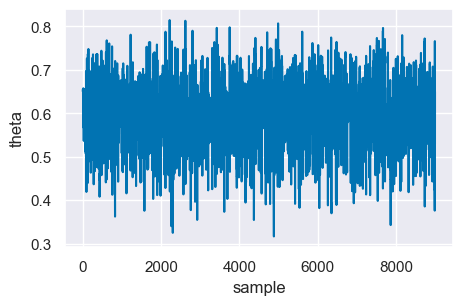

In [31]:
fig, ax = plt.subplots()
ax.plot(posterior[1001:10000])
_ = ax.set(xlabel="sample", ylabel="theta")

Nella figura, l'istogramma descrive i valori $\theta$ prodotti dall'algoritmo Metropolis mentre la linea continua descrive la distribuzione a posteriori ottenuta per via analitica, ovvero una $Beta(25, 17)$. La figura indica che la catena converge alla corretta distribuzione a posteriori.

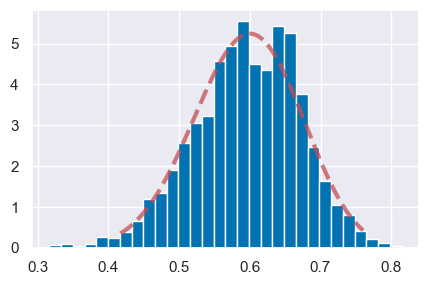

In [32]:
plt.hist(posterior[1001:10000], bins=30, label="estimated posterior", density=True)

a = 25
b = 17
x = np.linspace(stats.beta.ppf(0.01, a, b), stats.beta.ppf(0.99, a, b), 1000)
_ = plt.plot(x, stats.beta.pdf(x, a, b), "r--", lw=3, alpha=0.75, label="Beta(25, 17)")

In [33]:
az.summary(posterior[1001:10000], kind="stats", hdi_prob=0.95, round_to=2)

,mean,sd,hdi_2.5%,hdi_97.5%
x,0.6,0.07,0.46,0.74


La figura precedente si può generare con più facilità usando `az.plot_posterior()`. La curva che rappresenta l'intera distribuzione a posteriori e viene calcolata utilizzando la stima della densità del kernel (KDE) che serve a "lisciare" l'istogramma.

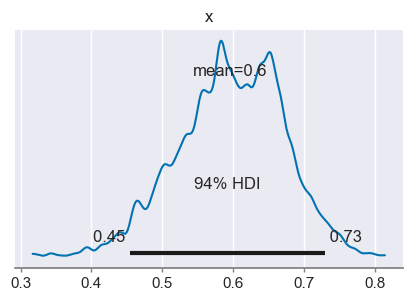

In [34]:
_ = az.plot_posterior(posterior[1001:10000])

L'HDI è una scelta comune nelle statistiche bayesiane e valori arrotondati come 50% o 95% sono molto popolari. Ma ArviZ utilizza il 94% come valore predefinito, come mostrato nella figura precedente. La ragione di questa scelta è che il 94% è vicino al valore ampiamente utilizzato del 95%, ma è anche diverso da questo, così da servire da "amichevole promemoria" che non c'è niente di speciale nella soglia del 5%. Idealmente sarebbe opportuno scegliere un valore che si adatti alle specifiche esigenze dell'analisi statistica che si sta svolgendo, o almeno riconoscere che si sta usando un valore arbitrario.

L'algoritmo descritto in questo capitolo è di {cite:t}`metropolist_etal_1953`. Un miglioramento di {cite:t}`hastings_1970` ha portato all'algoritmo Metropolis-Hastings. Il campionatore di Gibbs è dovuto a {cite}`geman_geman_1984`. L'approccio hamiltoniano Monte Carlo è dovuto a {cite:t}`duane1987hybrid` e il No-U-Turn Sampler (NUTS) è dovuto a {cite:t}`hoffman2014no`. Un'introduzione matematicamente intuitiva all'algoritmo Metropolis è data da {cite:t}`doing_bayesian_data_an`.

## Diagnostiche della soluzione MCMC

In questo capitolo abbiamo illustrato l'esecuzione di una singola catena di Markov in cui si parte un unico valore iniziale e si raccolgono i valori simulati da molte iterazioni. È possibile però che i valori di una catena siano influenzati dalla scelta del valore iniziale. Quindi una raccomandazione generale è di eseguire l'algoritmo Metropolis più volte utilizzando diversi valori di partenza. In questo caso, si avranno più catene di Markov. Confrontando le proprietà delle diverse catene si esplora la sensibilità dell'inferenza alla scelta del valore di partenza. I software MCMC consentono sempre all'utente di specificare diversi valori di partenza e di generare molteplici catene di Markov.

### Stazionarietà

Un punto importante da verificare è se il campionatore ha raggiunto la sua distribuzione stazionaria. La convergenza di una catena di Markov alla distribuzione stazionaria viene detta "mixing".

#### Autocorrelazione

Informazioni sul "mixing" della catena di Markov sono fornite dall'autocorrelazione. L'autocorrelazione misura la correlazione tra i valori successivi di una catena di Markov. Il valore $m$-esimo della serie ordinata viene confrontato con un altro valore ritardato di una quantità $k$ (dove $k$ è l'entità del ritardo) per verificare quanto si correli al variare di $k$. L'autocorrelazione di ordine 1 (*lag 1*) misura la correlazione tra valori successivi della catena di Markow (cioè, la correlazione tra $\theta^{(m)}$ e $\theta^{(m-1)}$); l'autocorrelazione di ordine 2 (*lag 2*) misura la correlazione tra valori della catena di Markow separati da due "passi" (cioè, la correlazione tra $\theta^{(m)}$ e $\theta^{(m-2)}$); e così via.

L'autocorrelazione di ordine $k$ è data da $\rho_k$ e può essere stimata come:

$$
\begin{align}
\rho_k &= \frac{Cov(\theta_m, \theta_{m+k})}{Var(\theta_m)}\notag\\
&= \frac{\sum_{m=1}^{n-k}(\theta_m - \bar{\theta})(\theta_{m-k} - \bar{\theta})}{\sum_{m=1}^{n-k}(\theta_m - \bar{\theta})^2} \qquad\text{con }\quad \bar{\theta} = \frac{1}{n}\sum_{m=1}^{n}\theta_m.
\end{align}
$$ (eq-autocor)

Per fare un esempio pratico, simuliamo dei dati autocorrelati.

In [35]:
x = pd.array([22, 24, 25, 25, 28, 29, 34, 37, 40, 44, 51, 48, 47, 50, 51])
print(*x)

22 24 25 25 28 29 34 37 40 44 51 48 47 50 51


L'autocorrelazione di ordine 1 è semplicemente la correlazione tra ciascun elemento e quello successivo nella sequenza.

In [36]:
sm.tsa.acf(x)

array([ 1.        ,  0.83174224,  0.65632458,  0.49105012,  0.27863962,
        0.03102625, -0.16527446, -0.30369928, -0.40095465, -0.45823389,
       -0.45047733, -0.36933174])

Nell'esempio, il vettore `x` è una sequenza temporale di 15 elementi. Il vettore $x'$ include gli elementi con gli indici da 0 a 13 nella sequenza originaria, mentre il vettore $x''$ include gli elementi 1:14. Gli elementi delle coppie ordinate dei due vettori avranno dunque gli indici $(0, 1)$, $(1, 2), (2, 3), \dots (13, 14)$ degli elementi della sequenza originaria. La correlazione di Pearson tra i vettori $x'$ e $x''$ corrisponde all'autocorrelazione di ordine 1 della serie temporale.

Nell'output precedente

-   0.83174224 è l'autocorrelazione di ordine 1 (lag = 1),
-   0.65632458 è l'autocorrelazione di ordine 2 (lag = 2),
-   0.49105012 è l'autocorrelazione di ordine 3 (lag = 3),
-   ecc.

È possibile specificare il numero di ritardi (*lag*) da utilizzare con l'argomento `nlags`:

In [37]:
sm.tsa.acf(x, nlags=4)

array([1.        , 0.83174224, 0.65632458, 0.49105012, 0.27863962])

Possiamo creare un grafico della funzione di autocorrelazione (correlogramma) per una serie temporale in Python usando la funzione `tsaplots.plot_acf()` dalla libreria `statsmodels`.

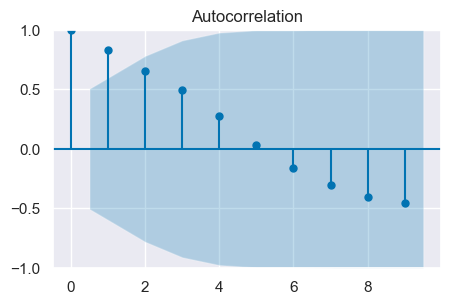

In [38]:
_ = tsaplots.plot_acf(x, lags=9)

Il correlogramma è uno strumento grafico usato per la valutazione della tendenza di una catena di Markov nel tempo. Il correlogramma si costruisce a partire dall'autocorrelazione $\rho_k$ di una catena di Markov in funzione del ritardo $k$ con cui l'autocorrelazione è calcolata: nel grafico ogni barretta verticale riporta il valore dell'autocorrelazione (sull'asse delle ordinate) in funzione del ritardo (sull'asse delle ascisse).

In situazioni ottimali l'autocorrelazione diminuisce rapidamente ed è effettivamente pari a 0 per piccoli lag. Ciò indica che i valori della catena di Markov che si trovano a più di soli pochi passi di distanza gli uni dagli altri non risultano associati tra loro, il che fornisce una conferma del "mixing" della catena di Markov, ossia della convergenza alla distribuzione stazionaria. Nelle analisi bayesiane, una delle strategie che consentono di ridurre l'autocorrelazione è quella di assottigliare l'output immagazzinando solo ogni $m$-esimo punto dopo il periodo di burn-in. Una tale strategia va sotto il nome di *thinning*.

### Test di convergenza

Un test di convergenza può essere svolto in maniera grafica mediante le tracce delle serie temporali (*trace plot*), cioè il grafico dei valori simulati rispetto al numero di iterazioni. Se la catena è in uno stato stazionario le tracce mostrano assenza di periodicità nel tempo e ampiezza costante, senza tendenze visibili o andamenti degni di nota. 

Ci sono inoltre alcuni test che permettono di verificare la stazionarietà del campionatore dopo un dato punto. Uno è il test di Geweke che suddivide il campione, dopo aver rimosso un periodo di burn in, in due parti. Se la catena è in uno stato stazionario, le medie dei due campioni dovrebbero essere uguali. Un test modificato, chiamato Geweke z-score, utilizza un test $z$ per confrontare i due subcampioni ed il risultante test statistico, se ad esempio è più alto di 2, indica che la media della serie sta ancora muovendosi da un punto ad un altro e quindi è necessario un periodo di burn-in più lungo.

## Commenti e considerazioni finali 

In generale, la distribuzione a posteriori dei parametri di un modello statistico non può essere determinata per via analitica. Tale problema viene invece affrontato facendo ricorso ad una classe di algoritmi per il campionamento da distribuzioni di probabilità che sono estremamente onerosi dal punto di vista computazionale e che possono essere utilizzati nelle applicazioni pratiche solo grazie alla potenza di calcolo dei moderni computer. Lo sviluppo di software che rendono sempre più semplice l'uso dei metodi MCMC, insieme all'incremento della potenza di calcolo dei computer, ha contribuito a rendere sempre più popolare il metodo dell'inferenza bayesiana che, in questo modo, può essere estesa a problemi di qualunque grado di complessità.

## Watermark

In [ ]:
%load_ext watermark
%watermark -n -u -v -iv -w